# Condition CVHM Water Level to DWR measured water level data

In [1]:
# First import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skgstat as skg

## Read Water level data
First we will read the DWR water level data. The data have been processed by [this python script](https://ucdavis.box.com/s/qe43f2t39k9ui8djojwub7gpoweagtlf)

We read all the wells measurements from 2011 - 2023. For each unique well code we calculated the mean, median and slope of the water table trend in ft/year. 
The dataset includes the number of water level measurmens.

The units of Meadia and Mean are in ft therefore we convert them to meters

In [2]:
WLmeas = pd.read_csv("G:\\Box\\VirtualWells\\SGMAdata\\WellsInCV.csv")
WLmeas.MEDIAN = WLmeas.MEDIAN*0.3048
WLmeas.MEAN = WLmeas.MEAN*0.3048
WLmeas.head()

,Unnamed: 0,X,Y,GSE,RPE,SLOPE,COUNT,MEDIAN,MEAN
0,0,-183587.112005,158172.144408,82.430,84.030,-0.236976,13,22.491192,22.245711
1,1,104862.767240,-303612.799271,514.492,514.492,5.160571,6,25.954330,25.336094
2,2,-113489.158266,-14029.651430,17.210,18.210,0.061719,6,-1.597152,-1.607312
3,3,-96842.210258,9224.974078,117.350,117.350,-0.152069,4,-16.593312,-16.583406
4,4,-37232.652788,-105718.906624,162.720,163.220,-14.827586,5,1.895856,-0.542544


## Filter Water level measured data
From the data we will select the wells that have more than 6 water level measurments, which means that we there are at least six years of measurments and the slope is less that 1 ft/year 

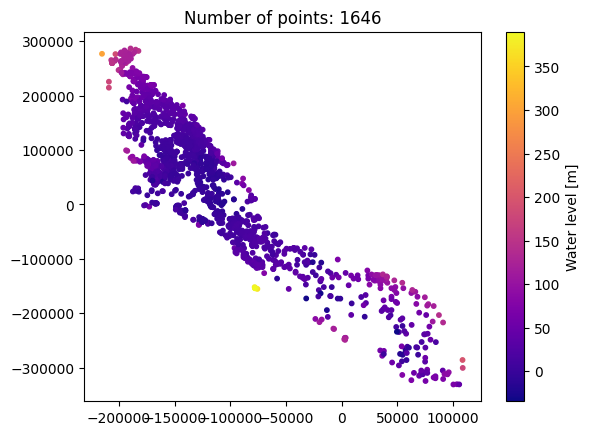

In [3]:
idx = np.where((WLmeas.COUNT > 6) & (abs(WLmeas.SLOPE) < 1))[0]
fig, ax = plt.subplots()
pc = ax.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'plasma')
ax.set_title("Number of points: %d" %len(idx))
plt.colorbar(pc, ax = ax,label="Water level [m]")
plt.show()

In [113]:
# Write the filtered data
np.savetxt('G:\\Box\\VirtualWells\\SGMAdata\\WL_FilteredData.dat',list(zip(WLmeas.X[idx], WLmeas.Y[idx], WLmeas.MEDIAN[idx])))

## Create a kriging interpolant


spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   399998.61
Sill:              3430.55
Nugget:            0.00
        


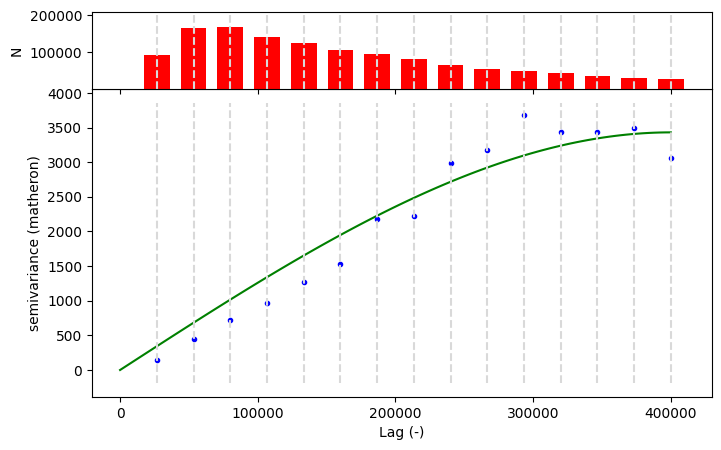

In [129]:
coords = np.column_stack((np.array(WLmeas.X[idx],dtype = np.float64),np.array(WLmeas.Y[idx],dtype = np.float64)))
vals = np.array(WLmeas.MEDIAN[idx],dtype = np.float64)
Vmeas = skg.Variogram(coords, vals, maxlag=400000, n_lags=15, normalize=False, model='Spherical')
fig = Vmeas.plot(show=False)
print(Vmeas)
ok_meas = skg.OrdinaryKriging(Vmeas, min_points=5, max_points=15, mode='exact')

## CVHM simulated Water level
### Read the average simulated water table elevation.

In [5]:
cvhm_WL = pd.read_table("G:\\Box\\CVHMII\\NPSAT\\AvHeads_09_19.dat",sep =",",header=None,names=['X', 'Y', 'WL'])
cvhm_WL.head()

,X,Y,WL
0,-195362.772123,297703.212524,212.047296
1,-197338.489906,294712.198443,199.887646
2,-195939.132754,295519.786242,196.209617
3,-194539.771117,296327.377248,203.090354
4,-193140.404995,297134.971464,209.139783


### Calculate a kriging interpolant for the simulated values

exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   192505.92
Sill:              2252.52
Nugget:            0.00
        


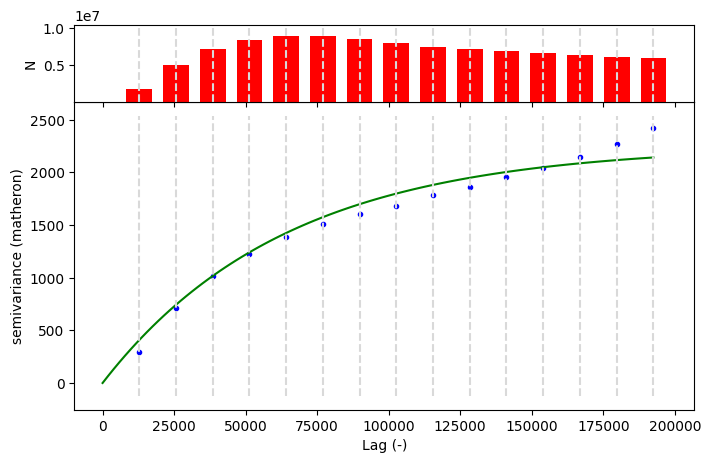

In [130]:
coords_sim = np.column_stack((np.array(cvhm_WL.X, dtype = np.float64),np.array(cvhm_WL.Y, dtype = np.float64)))
vals_sim = np.array(cvhm_WL.WL, dtype = np.float64)
Vsim = skg.Variogram(coords_sim, vals_sim, maxlag='median', n_lags=15, normalize=False, model='Exponential')
fig = Vsim.plot(show=False)
print(Vsim)
ok_sim = skg.OrdinaryKriging(Vsim, min_points=5, max_points=15, mode='exact')

## Condition the Simulated water level to the measured data
**1. Calculate the simulated values on the measured data using the simulated interpolant**

In [131]:
SimValOnWLpnts = ok_sim.transform(WLmeas.X[idx], WLmeas.Y[idx])

Plot the simulated and the measured values on the water level measured points

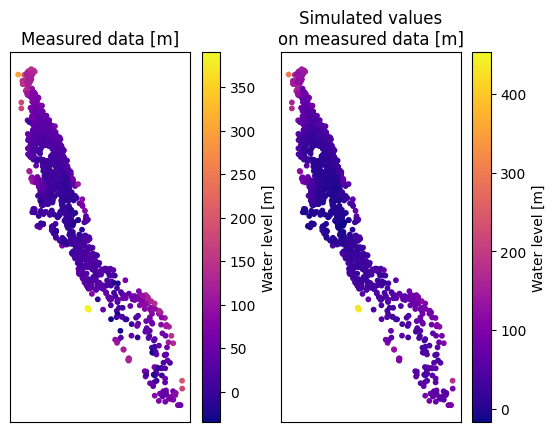

In [132]:
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.tight_layout(pad=7.0)
pc1 = ax1.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'plasma')
pc2 = ax2.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = SimValOnWLpnts.T, s = 10, cmap = 'plasma')
ax1.set_title("Measured data [m]")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.set_title("Simulated values\non measured data [m]")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
plt.colorbar(pc1, ax = ax1,label="Water level [m]")
plt.colorbar(pc2, ax = ax2,label="Water level [m]")
#plt.subplots_adjust(wspace=1.4)
plt.show()

**2 Build a kriging interpolant using the measured data points with the simulated values**

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   390572.46
Sill:              3503.52
Nugget:            0.00
        


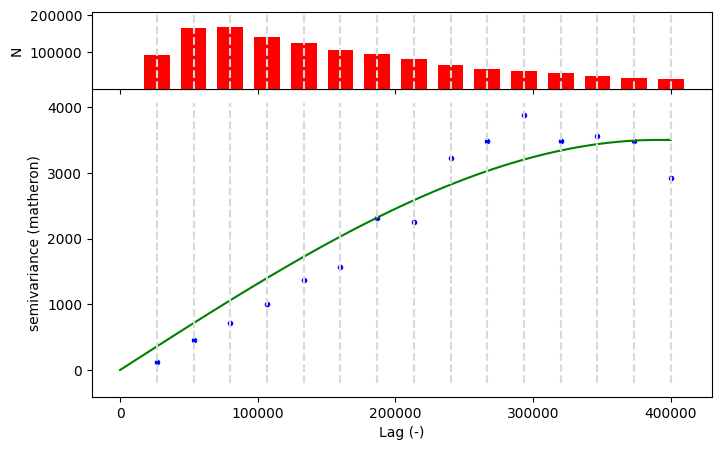

In [133]:
vals_SimonMeas = np.array(SimValOnWLpnts.T, dtype = np.float64)
VsimOnMeas = skg.Variogram(coords, vals_SimonMeas, maxlag=400000, n_lags=15, normalize=False, model='Spherical')
fig = VsimOnMeas.plot(show=False)
print(VsimOnMeas)
ok_SimOnmeas = skg.OrdinaryKriging(VsimOnMeas, min_points=5, max_points=15, mode='exact')

**3 Use the previous interpolant to calculate Simulated values on the simulation points**

In [134]:
SimValOnSimpnts = ok_SimOnmeas.transform(cvhm_WL.X, cvhm_WL.Y)

**4 Calculate the Interpolation error**

In [135]:
interpError = cvhm_WL.WL - SimValOnSimpnts.T

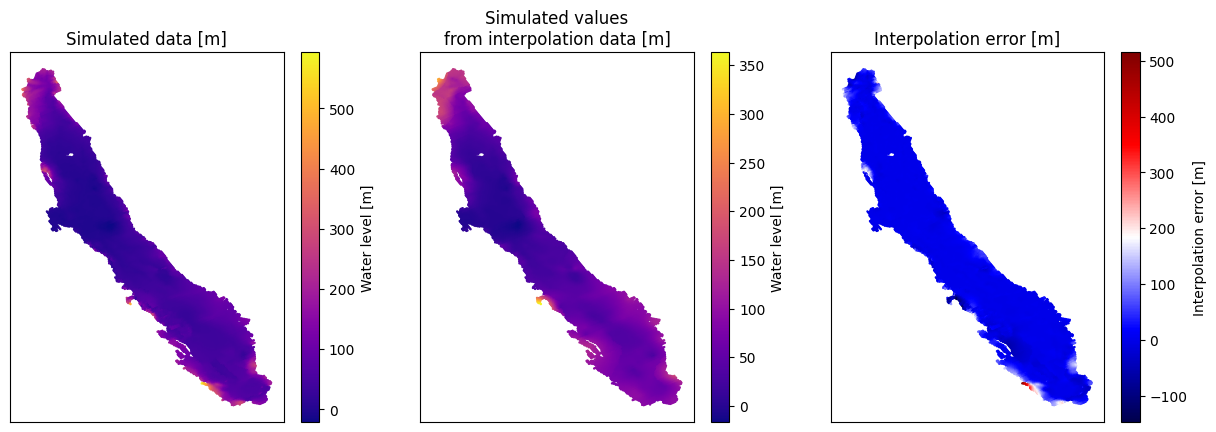

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
#fig.tight_layout(pad=7.0)
pc1 = ax1.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = cvhm_WL.WL, s = .5, cmap = 'plasma')
pc2 = ax2.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = SimValOnSimpnts.T, s = .5, cmap = 'plasma')
pc3 = ax3.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = interpError, s = .5, cmap = 'seismic')
ax1.set_title("Simulated data [m]")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.set_title("Simulated values\nfrom interpolation data [m]")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.set_title("Interpolation error [m]")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.colorbar(pc1, ax = ax1,label="Water level [m]")
plt.colorbar(pc2, ax = ax2,label="Water level [m]")
plt.colorbar(pc3, ax = ax3,label="Interpolation error [m]")
#plt.subplots_adjust(wspace=1.4)

plt.show()

**5 Interpolate the Water level data onto the simulated points**

In [137]:
WLonSim = ok_meas.transform(cvhm_WL.X, cvhm_WL.Y)

In [138]:
WL_Conditioned = WLonSim + interpError

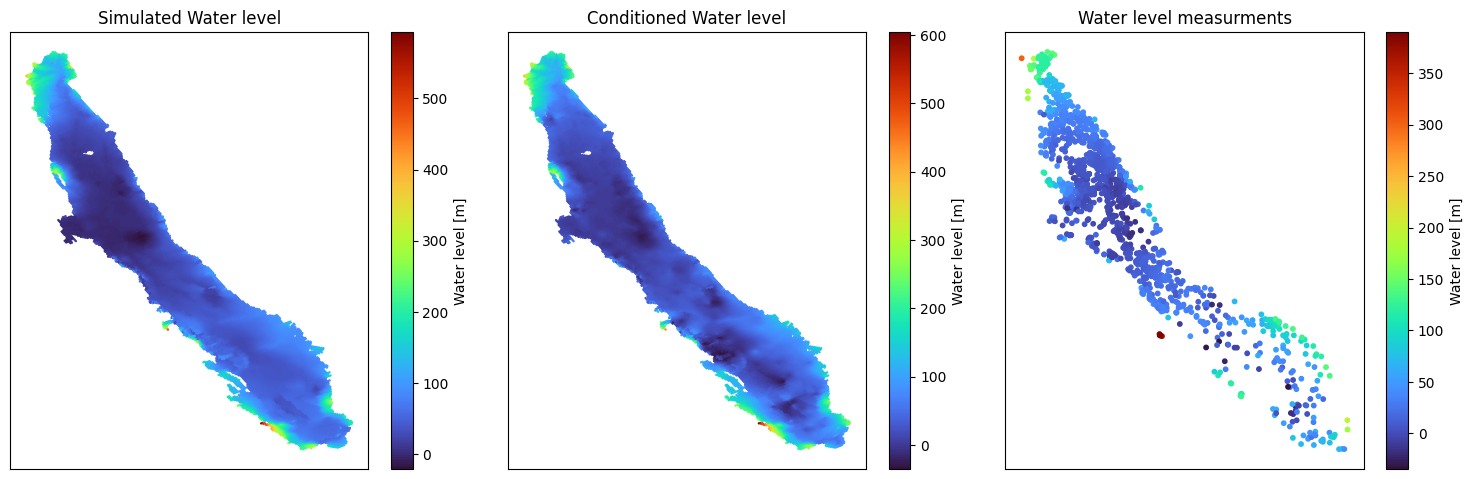

In [139]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
fig.tight_layout(pad=0.5)
pc1 = ax1.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = cvhm_WL.WL, s = 0.5, cmap = 'turbo')
plt.colorbar(pc1, ax = ax1, label="Water level [m]")
ax1.set_title("Simulated Water level")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

pc2 = ax2.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = WL_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc2, ax = ax2, label="Water level [m]")
ax2.set_title("Conditioned Water level")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

pc3 = ax3.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'turbo')
plt.colorbar(pc3, ax = ax3, label="Water level [m]")
ax3.set_title("Water level measurments")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.show()

In [140]:
# Write the interpolation outcome to a table
#np.savetxt('G:\\Box\\CVHMII\\NPSAT\\WL_Krig.dat',list(zip(cvhm_WL.X, cvhm_WL.Y, WL_Conditioned)))
np.savetxt('G:\\Box\\CVHMII\\NPSAT\\WL_Krigexp.dat',list(zip(cvhm_WL.X, cvhm_WL.Y, WL_Conditioned)))

# Linear Interpolation
Import the required library

In [19]:
from scipy.interpolate import LinearNDInterpolator

Create linear interpolants for the measured and the simulated water level data

In [20]:
Linterp_Meas = LinearNDInterpolator(list(zip(WLmeas.X[idx], WLmeas.Y[idx])), WLmeas.MEDIAN[idx])
Linterp_Sim = LinearNDInterpolator(list(zip(cvhm_WL.X, cvhm_WL.Y)), cvhm_WL.WL)

Interpolate the Simulated values on the water level measured points

In [21]:
L_SimOnMeasPnt = Linterp_Sim(WLmeas.X[idx], WLmeas.Y[idx])

Build interpolant using the measurement points with the interpolated simulated values on them

In [23]:
Linterp_SimOnMeasPnts = LinearNDInterpolator(list(zip(WLmeas.X[idx], WLmeas.Y[idx])), L_SimOnMeasPnt)

Use the interpolant to interpolate on the simulated points new simulated values and calculate the interpolation error

In [25]:
L_SimOnSim = Linterp_SimOnMeasPnts(cvhm_WL.X, cvhm_WL.Y)
Lerror = cvhm_WL.WL - L_SimOnSim

Use the actual measured water leve interpolant to find the water level on the simulated points and correct twith the error

In [26]:
L_MeasOnSim = Linterp_Meas(cvhm_WL.X, cvhm_WL.Y)
L_Conditioned = L_MeasOnSim + Lerror

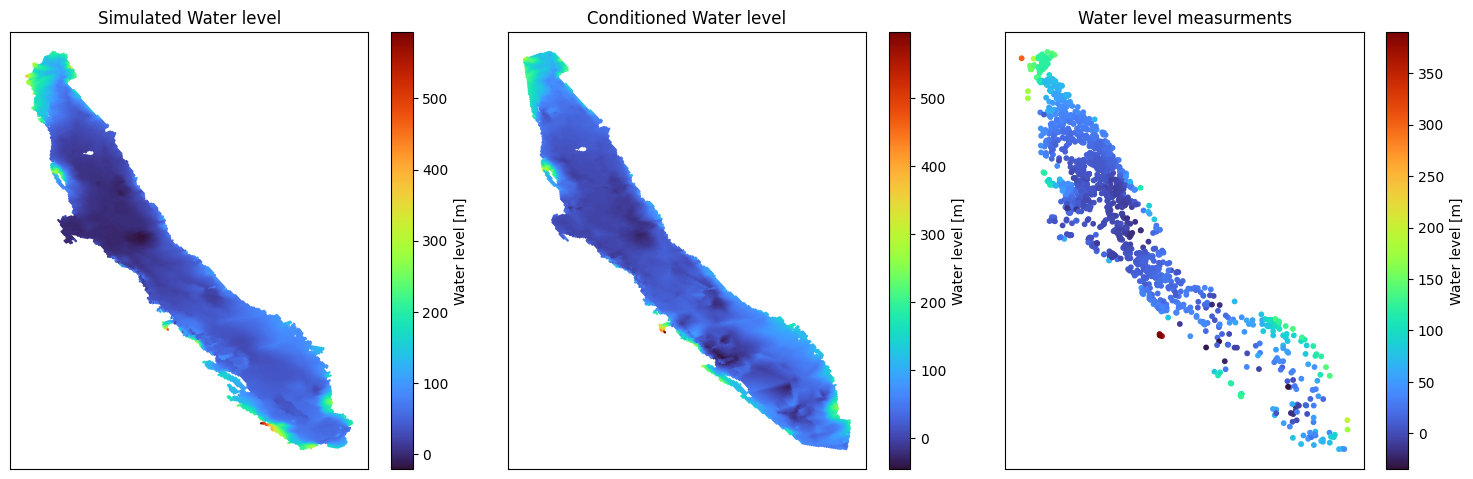

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
fig.tight_layout(pad=0.5)
pc1 = ax1.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = cvhm_WL.WL, s = 0.5, cmap = 'turbo')
plt.colorbar(pc1, ax = ax1, label="Water level [m]")
ax1.set_title("Simulated Water level")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

pc2 = ax2.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = L_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc2, ax = ax2, label="Water level [m]")
ax2.set_title("Conditioned Water level")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

pc3 = ax3.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'turbo')
plt.colorbar(pc3, ax = ax3, label="Water level [m]")
ax3.set_title("Water level measurments")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.show()

In [109]:
# Write the conditioned water table
np.savetxt('G:\\Box\\CVHMII\\NPSAT\\WL_LinearPY.dat',list(zip(cvhm_WL.X, cvhm_WL.Y, L_Conditioned)))

# Clough-Tocher Interpolation
Import the required library

In [37]:
from scipy.interpolate import CloughTocher2DInterpolator

Create linear interpolants for the measured and the simulated water level data

In [38]:
CTinterp_Meas = CloughTocher2DInterpolator(list(zip(WLmeas.X[idx], WLmeas.Y[idx])), WLmeas.MEDIAN[idx])
CTinterp_Sim = CloughTocher2DInterpolator(list(zip(cvhm_WL.X, cvhm_WL.Y)), cvhm_WL.WL)

Interpolate the Simulated values on the water level measured points

In [39]:
CT_SimOnMeasPnt = CTinterp_Sim(WLmeas.X[idx], WLmeas.Y[idx])

Build interpolant using the measurement points with the interpolated simulated values on them

In [40]:
CTinterp_SimOnMeasPnts = CloughTocher2DInterpolator(list(zip(WLmeas.X[idx], WLmeas.Y[idx])), CT_SimOnMeasPnt)

Use the interpolant to interpolate on the simulated points new simulated values and calculate the interpolation error

In [41]:
CT_SimOnSim = CTinterp_SimOnMeasPnts(cvhm_WL.X, cvhm_WL.Y)
CTerror = cvhm_WL.WL - CT_SimOnSim

Use the actual measured water leve interpolant to find the water level on the simulated points and correct twith the error

In [42]:
CT_MeasOnSim = CTinterp_Meas(cvhm_WL.X, cvhm_WL.Y)
CT_Conditioned = CT_MeasOnSim + CTerror

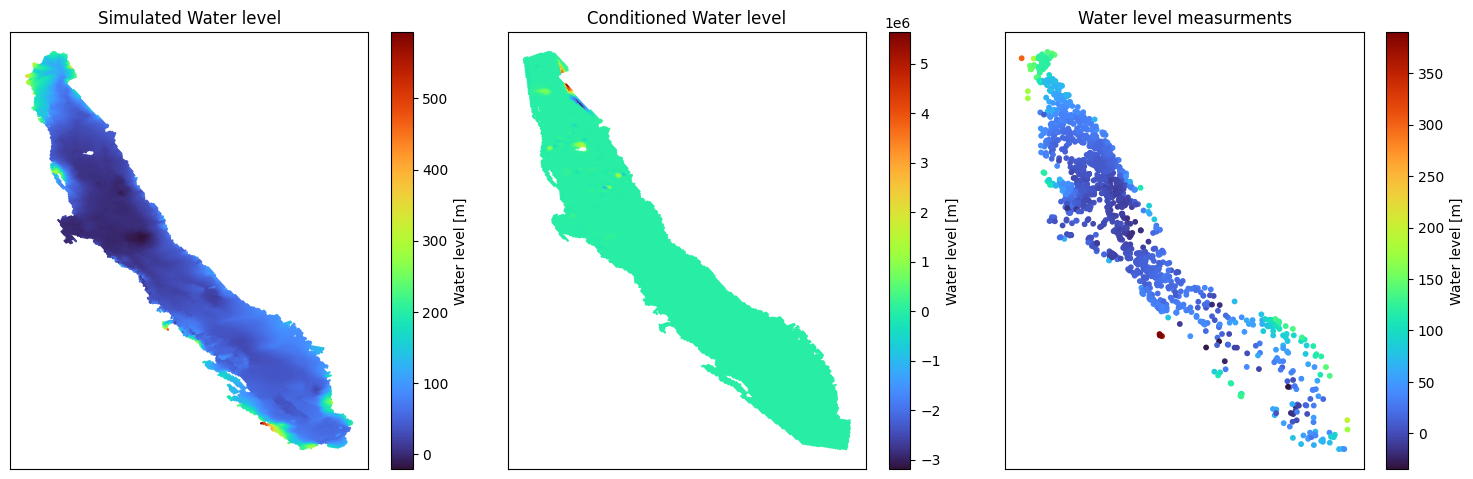

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
fig.tight_layout(pad=0.5)
pc1 = ax1.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = cvhm_WL.WL, s = 0.5, cmap = 'turbo')
plt.colorbar(pc1, ax = ax1, label="Water level [m]")
ax1.set_title("Simulated Water level")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

pc2 = ax2.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = CT_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc2, ax = ax2, label="Water level [m]")
ax2.set_title("Conditioned Water level")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

pc3 = ax3.scatter(x=WLmeas.X[idx], y=WLmeas.Y[idx], c = WLmeas.MEDIAN[idx], s = 10, cmap = 'turbo')
plt.colorbar(pc3, ax = ax3, label="Water level [m]")
ax3.set_title("Water level measurments")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.show()

# Radial Basis Function interpolation
import the required library

In [44]:
from scipy.interpolate import RBFInterpolator

In [102]:
# Set the maximum neighbor points for the measured and simulated data
neigh_sim = 20
neigh_meas = 20
selected_kernel = "gaussian"
smooth = 0.1
epsil =300

# Create the interpolants
RBFinterp_Meas = RBFInterpolator(list(zip(WLmeas.X[idx], WLmeas.Y[idx])), WLmeas.MEDIAN[idx],neighbors=neigh_meas, kernel=selected_kernel, smoothing=smooth, epsilon=epsil )
RBFinterp_Sim = RBFInterpolator(list(zip(cvhm_WL.X, cvhm_WL.Y)), cvhm_WL.WL, neighbors=neigh_sim, kernel=selected_kernel, smoothing=smooth, epsilon=epsil)

# Interpolate the simulated values on the measured points
RBF_SimOnMeasPnt = RBFinterp_Sim(list(zip(WLmeas.X[idx], WLmeas.Y[idx])))

# Build interpolant using the measurement points with the interpolated simulated values on them
RBFinterp_SimOnMeasPnts = RBFInterpolator(list(zip(WLmeas.X[idx], WLmeas.Y[idx])), RBF_SimOnMeasPnt,neighbors=neigh_meas,kernel=selected_kernel, smoothing=smooth, epsilon=epsil)

# Use the interpolant to interpolate on the simulated points new simulated values and calculate the interpolation error
RBF_SimOnSim = RBFinterp_SimOnMeasPnts(list(zip(cvhm_WL.X, cvhm_WL.Y)))
RBFerror = cvhm_WL.WL - RBF_SimOnSim

# Use the actual measured water leve interpolant to find the water level on the simulated points and correct twith the error
RBF_MeasOnSim = RBFinterp_Meas(list(zip(cvhm_WL.X, cvhm_WL.Y)))
RBF_Conditioned = RBF_MeasOnSim + RBFerror

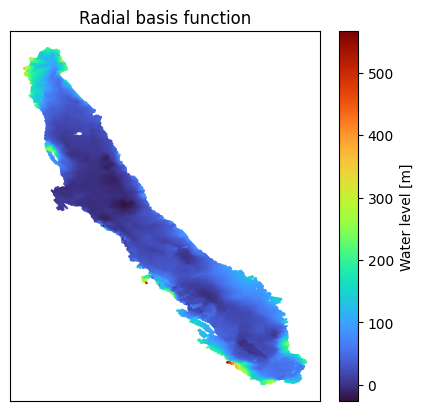

In [107]:
fig, ax = plt.subplots()
fig.set_figwidth(5)
#fig.tight_layout(pad=0.5)
pc = ax.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = RBF_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc, ax = ax, label="Water level [m]")
ax.set_title("Radial basis function")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [110]:
# Write the conditioned water table
np.savetxt('G:\\Box\\CVHMII\\NPSAT\\WL_RBF.dat',list(zip(cvhm_WL.X, cvhm_WL.Y, RBF_Conditioned)))

## Compare all interpolation results

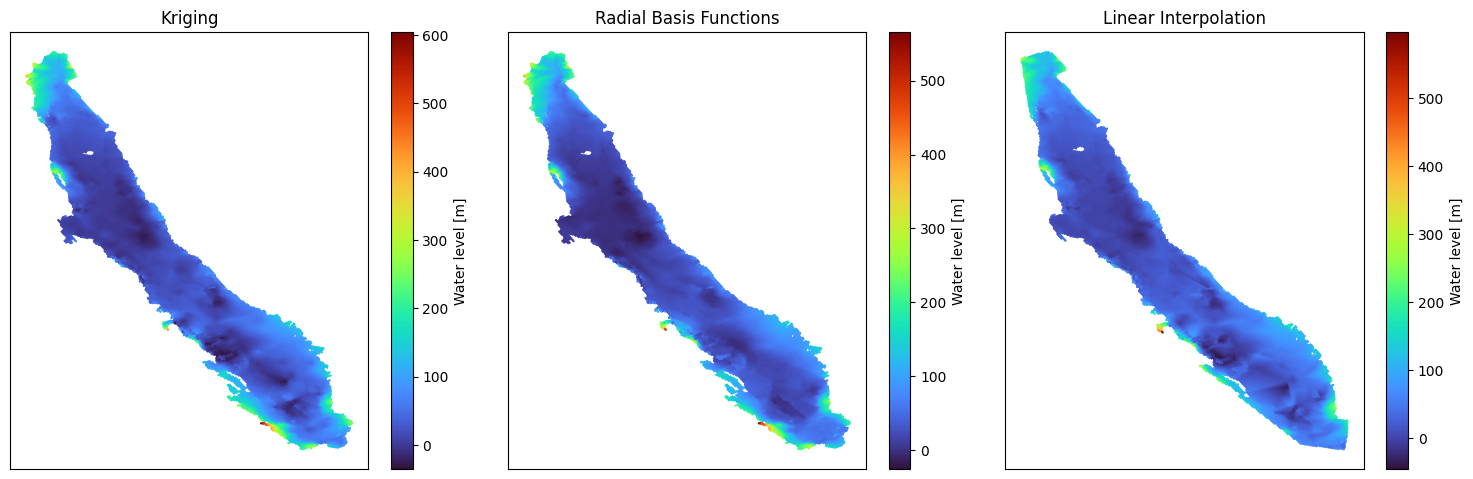

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
fig.tight_layout(pad=0.5)
pc1 = ax1.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = WL_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc1, ax = ax1, label="Water level [m]")
ax1.set_title("Kriging")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

pc2 = ax2.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = RBF_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc2, ax = ax2, label="Water level [m]")
ax2.set_title("Radial Basis Functions")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

pc3 = ax3.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = L_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc3, ax = ax3, label="Water level [m]")
ax3.set_title("Linear Interpolation")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.show()

## Interpolation discrepancy between the methods

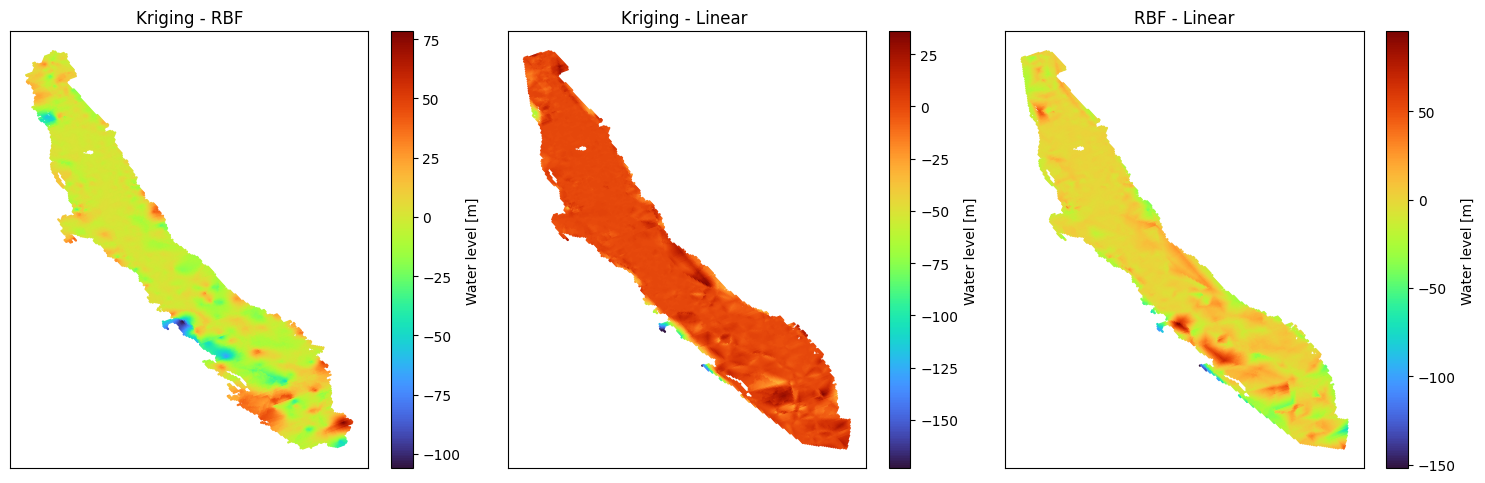

In [111]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figwidth(15)
fig.tight_layout(pad=0.5)
pc1 = ax1.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = WL_Conditioned - RBF_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc1, ax = ax1, label="Water level [m]")
ax1.set_title("Kriging - RBF")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

pc2 = ax2.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = WL_Conditioned - L_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc2, ax = ax2, label="Water level [m]")
ax2.set_title("Kriging - Linear ")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

pc3 = ax3.scatter(x=cvhm_WL.X, y=cvhm_WL.Y, c = RBF_Conditioned - L_Conditioned, s = 0.5, cmap = 'turbo')
plt.colorbar(pc3, ax = ax3, label="Water level [m]")
ax3.set_title("RBF - Linear")
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
plt.show()